In [119]:
#Libaries 
# ignores warnings 
import warnings
warnings.filterwarnings('ignore')

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
import tarfile
import datetime 
import matplotlib.dates as mdates 
from scipy import stats
from api_keys import api_key
from api_keys import g_key



In [120]:
# set the year 
# since=2005
# until=2016

In [121]:
# pull the API
# url_crime=(f"https://api.usa.gov/crime/fbi/sapi/api/data/arrest/national/offense/monthly/{since}/{until}?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv")
# url_crime

In [122]:
# Make pretty print
#response = requests.get(url_crime)
#response_json = response.json()
#print(json.dumps(response_json, indent=4, sort_keys=True))

In [123]:
## fine out the size of the tar file
# tar = tarfile.open("Crime_DataFiles/DATA_01-2013_03-2018.tar.gz", "r:gz")
# for tarinfo in tar:
#     print(tarinfo.name, "is", tarinfo.size, "bytes in size and is ", end="")
#     if tarinfo.isreg():
#         print("a regular file.")
#     elif tarinfo.isdir():
#         print("a directory.")
#     else:
#         print("something else.")
# tar.close()

# Tar file

In [124]:
# read tar g.zip file - tar.zip file can load to main repo 
df = pd.read_csv('Crime_DataFiles/DATA_01-2013_03-2018.tar.gz', compression='gzip', header=0, sep=',', error_bad_lines=False)

In [125]:
# check column values
crime_df = pd.DataFrame(df)
print(crime_df.columns.values)

['stage3.csv' 'date' 'state' 'city_or_county' 'address' 'n_killed'
 'n_injured' 'incident_url' 'source_url' 'incident_url_fields_missing'
 'congressional_district' 'gun_stolen' 'gun_type'
 'incident_characteristics' 'latitude' 'location_description' 'longitude'
 'n_guns_involved' 'notes' 'participant_age' 'participant_age_group'
 'participant_gender' 'participant_name' 'participant_relationship'
 'participant_status' 'participant_type' 'sources' 'state_house_district'
 'state_senate_district']


In [126]:
# create crime dataframe and rename columns
crime_df = pd.DataFrame(df, columns = ['stage3.csv','date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'participant_gender','participant_age_group','latitude','longitude'])
crime_df.rename(columns ={'stage3.csv':'Incident','date':'Date','state':'State','city_or_county':'City or Country',
                           'n_killed':'Number Killed','n_injured':'Number Injured','participant_gender':'Gender Involved',
                           'participant_age_group':'Age Group','latitude':'Latitude','longitude':'Longitude'}, inplace=True)
crime_df.head()

,Incident,Date,State,City or Country,Number Killed,Number Injured,Gender Involved,Age Group,Latitude,Longitude
0,461105.0,2013-01-01,Pennsylvania,Mckeesport,0.0,4.0,0::Male||1::Male||3::Male||4::Female,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,40.3467,-79.8559
1,460726.0,2013-01-01,California,Hawthorne,1.0,3.0,0::Male,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,33.9090,-118.3330
2,478855.0,2013-01-01,Ohio,Lorain,1.0,3.0,0::Male||1::Male||2::Male||3::Male||4::Male,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,41.4455,-82.1377
3,478925.0,2013-01-05,Colorado,Aurora,4.0,0.0,0::Female||1::Male||2::Male||3::Male,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,39.6518,-104.8020
4,478959.0,2013-01-07,North Carolina,Greensboro,2.0,2.0,0::Female||1::Male||2::Male||3::Female,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,36.1140,-79.9569


In [127]:
# Try to 2 year of data for Obama and Trump Presidency,but we find out there was no data after 3/31/2018. 
ObamaTrump_df = crime_df.loc[(crime_df['Date']>='2015-01-01') & (crime_df['Date']<'20190101')]
ObamaTrump_df['Date'].max()

'2018-03-31'

In [128]:
# Add Column Name - Presidency and fill in base on 15 months of Obama and Trump was President
# Fill in the column Presidency - Obama or Trump based on Date column. 
ObamaTrump_df.loc[(ObamaTrump_df['Date']>='2015-01-01') & (ObamaTrump_df['Date'] <'2016-04-01'), 'Presidency'] ='Obama'
ObamaTrump_df.loc[(ObamaTrump_df['Date']>='2017-01-01') & (ObamaTrump_df['Date'] <'2018-04-01'), 'Presidency'] ='Trump'
ObamaTrump_df.head()

,Incident,Date,State,City or Country,Number Killed,Number Injured,Gender Involved,Age Group,Latitude,Longitude,Presidency
52132,274168.0,2015-01-01,Oklahoma,Tulsa,0.0,2.0,0::Female||1::Male,0::Adult 18+||1::Adult 18+,36.0934,-95.8870,Obama
52133,276211.0,2015-01-01,Louisiana,Labadieville,1.0,0.0,0::Male,0::Adult 18+,29.8312,-90.9609,Obama
52134,272302.0,2015-01-01,Mississippi,Hattiesburg,0.0,0.0,0::Male,0::Adult 18+,31.3271,-89.2903,Obama
52135,272482.0,2015-01-01,Alabama,Bessemer,0.0,2.0,0::Male||1::Male,NaN,33.4423,-86.9322,Obama
52136,272487.0,2015-01-01,Illinois,Chicago,0.0,1.0,0::Male,NaN,41.9202,-87.7857,Obama


## Parse Gender Involved and Age Group

In [129]:
# Parse Gender Involved and Age Group to its own columns and add Year Month 
ObamaTrump_df['Male'] = ObamaTrump_df['Gender Involved'].str.count('Male')
ObamaTrump_df['Female'] = ObamaTrump_df['Gender Involved'].str.count('Female')
ObamaTrump_df['Child 0-11'] = ObamaTrump_df['Age Group'].str.count('Child 0-11')
ObamaTrump_df['Teen 12-17'] = ObamaTrump_df['Age Group'].str.count('Teen 12-17')
ObamaTrump_df['Adult 18+'] = ObamaTrump_df['Age Group'].str.count('Adult 18+')
ObamaTrump_df['Year Month'] = pd.DatetimeIndex(ObamaTrump_df['Date']).to_period('M')
#ObamaTrump_df['Year Month'] = pd.to_datetime(ObamaTrump_df['Date']).dt.to_period('M')
#ObamaTrump_df['Year Month'] = [''.join(x.split('-')[0:2]) for x in ObamaTrump_df.Date]
ObamaTrump_df.head()

#output_file = "Crime_DataFiles/test_analysis.csv"
#ObamaTrump_df.to_csv(output_file, index = False)

,Incident,Date,State,City or Country,Number Killed,Number Injured,Gender Involved,Age Group,Latitude,Longitude,Presidency,Male,Female,Child 0-11,Teen 12-17,Adult 18+,Year Month
52132,274168.0,2015-01-01,Oklahoma,Tulsa,0.0,2.0,0::Female||1::Male,0::Adult 18+||1::Adult 18+,36.0934,-95.8870,Obama,1.0,1.0,0.0,0.0,2.0,2015-01
52133,276211.0,2015-01-01,Louisiana,Labadieville,1.0,0.0,0::Male,0::Adult 18+,29.8312,-90.9609,Obama,1.0,0.0,0.0,0.0,1.0,2015-01
52134,272302.0,2015-01-01,Mississippi,Hattiesburg,0.0,0.0,0::Male,0::Adult 18+,31.3271,-89.2903,Obama,1.0,0.0,0.0,0.0,1.0,2015-01
52135,272482.0,2015-01-01,Alabama,Bessemer,0.0,2.0,0::Male||1::Male,NaN,33.4423,-86.9322,Obama,2.0,0.0,NaN,NaN,NaN,2015-01
52136,272487.0,2015-01-01,Illinois,Chicago,0.0,1.0,0::Male,NaN,41.9202,-87.7857,Obama,1.0,0.0,NaN,NaN,NaN,2015-01


In [130]:
# Data cleaning - Drop null/NaN values on Presidency fields 
ObamaTrump_df.dropna(subset=['Presidency'],inplace=True)


In [131]:
# Export Data result to CSV file - work with a smaller subset of data
output_file = "Crime_DataFiles/crime_analysis.csv"
ObamaTrump_df.to_csv(output_file, index = False)

### Read Data From Export CSV  

In [132]:
# Run using a subset of data exported out for analysis
# read csv
crime_file= "Crime_DataFiles/crime_analysis.csv"
re_Crime =pd.read_csv(crime_file)
re_Crime.head()

,Incident,Date,State,City or Country,Number Killed,Number Injured,Gender Involved,Age Group,Latitude,Longitude,Presidency,Male,Female,Child 0-11,Teen 12-17,Adult 18+,Year Month
0,274168.0,2015-01-01,Oklahoma,Tulsa,0.0,2.0,0::Female||1::Male,0::Adult 18+||1::Adult 18+,36.0934,-95.8870,Obama,1.0,1.0,0.0,0.0,2.0,2015-01
1,276211.0,2015-01-01,Louisiana,Labadieville,1.0,0.0,0::Male,0::Adult 18+,29.8312,-90.9609,Obama,1.0,0.0,0.0,0.0,1.0,2015-01
2,272302.0,2015-01-01,Mississippi,Hattiesburg,0.0,0.0,0::Male,0::Adult 18+,31.3271,-89.2903,Obama,1.0,0.0,0.0,0.0,1.0,2015-01
3,272482.0,2015-01-01,Alabama,Bessemer,0.0,2.0,0::Male||1::Male,NaN,33.4423,-86.9322,Obama,2.0,0.0,NaN,NaN,NaN,2015-01
4,272487.0,2015-01-01,Illinois,Chicago,0.0,1.0,0::Male,NaN,41.9202,-87.7857,Obama,1.0,0.0,NaN,NaN,NaN,2015-01


## Obama vs Trump by Months, Counts

In [133]:
# Summary by months - for graphs
Total_Incident = re_Crime.groupby("Year Month").count()['Incident']
killed = re_Crime.groupby(["Year Month"]).sum()["Number Killed"]
injured = re_Crime.groupby(["Year Month"]).sum()["Number Injured"]
male = re_Crime.groupby(["Year Month"]).sum()["Male"]
female = re_Crime.groupby(["Year Month"]).sum()["Female"]
child = re_Crime.groupby(["Year Month"]).sum()["Child 0-11"]
teen = re_Crime.groupby(["Year Month"]).sum()["Teen 12-17"]
adult = re_Crime.groupby(["Year Month"]).sum()["Adult 18+"]

summary_months = pd.DataFrame({
                             
                             "Total Incidents":Total_Incident,
                              "Male":male,
                              "Female":female,
                              "Killed":killed,
                              "Injured":injured,
                              "Child":child,
                              "Teen":teen,
                              "Adult":adult
                             })
summary_months.head()

,Total Incidents,Male,Female,Killed,Injured,Child,Teen,Adult
Year Month,,,,,,,,
2015-01,3907,5105.0,670.0,1123.0,1808.0,71.0,397.0,5129.0
2015-02,3108,3803.0,620.0,870.0,1378.0,64.0,299.0,3895.0
2015-03,4314,5527.0,842.0,1090.0,2093.0,110.0,483.0,5550.0
2015-04,4471,5524.0,814.0,995.0,2149.0,87.0,414.0,5650.0
2015-05,5015,6453.0,873.0,1164.0,2677.0,127.0,508.0,6450.0


In [134]:
#graph
# Pandas can also plot multiple columns if the DataFrame includes them


# multi_plot = summary_months.plot(kind="bar", figsize=(45,5))
# multi_plot.legend(loc=9, bbox_to_anchor=(0.5, -0.25), ncol=4)
# ax.patch.set_facecolor('white')
# # Plot x and y labels and title
# plt.title('Crime Incidents/Involvements by Year Month')
# plt.xlabel('Year Months')
# plt.ylabel('Numbers')

# plt.savefig("Images/CrimeIncidentInvolvbyYearMonth.png")
# plt.show()
# plt.tight_layout()


In [135]:
# Summary Obama
re_Crime_df= re_Crime.loc[(re_Crime["Presidency"] == 'Obama')]
cnt_Incident = re_Crime_df.groupby('Presidency').count()['Incident']
Male = re_Crime_df.groupby('Presidency').sum()['Male']
Female = re_Crime_df.groupby('Presidency').sum()['Female']
Killed = re_Crime_df.groupby('Presidency').sum()['Number Killed']
Injured = re_Crime_df.groupby('Presidency').sum()['Number Injured']
Child = re_Crime_df.groupby('Presidency').sum()['Child 0-11']
Teen = re_Crime_df.groupby('Presidency').sum()['Teen 12-17']
Adult = re_Crime_df.groupby('Presidency').sum()['Adult 18+']

summary_Obama = pd.DataFrame({"Total Incidents":cnt_Incident,
                              "Male_Involved":Male,
                              "Female_Involved":Female,
                              "Numbers Killed":Killed,
                              "Numbers Injured":Injured,
                              "Numbers Child":Child,
                              "Numbers Teen":Teen,
                              "Numbers Adult":Adult
                             })


summary_Obama.head()

,Total Incidents,Male_Involved,Female_Involved,Numbers Killed,Numbers Injured,Numbers Child,Numbers Teen,Numbers Adult
Presidency,,,,,,,,
Obama,67028,86248.0,12207.0,16788.0,33511.0,1317.0,7150.0,84035.0


In [136]:
# Summary Trump
re_Crime_df= re_Crime.loc[(re_Crime["Presidency"] == 'Trump')]
cnt_Incident = re_Crime_df.groupby("Presidency").count()['Incident']
Male = re_Crime_df.groupby('Presidency').sum()['Male']
Female = re_Crime_df.groupby('Presidency').sum()['Female']
Killed = re_Crime_df.groupby('Presidency').sum()['Number Killed']
Injured = re_Crime_df.groupby('Presidency').sum()['Number Injured']
Child = re_Crime_df.groupby('Presidency').sum()['Child 0-11']
Teen = re_Crime_df.groupby('Presidency').sum()['Teen 12-17']
Adult = re_Crime_df.groupby('Presidency').sum()['Adult 18+']

summary_Trump = pd.DataFrame({     "Total Incidents":cnt_Incident,
                              "Male_Involved":Male,
                              "Female_Involved":Female,
                              "Numbers Killed":Killed,
                              "Numbers Injured":Injured,
                              "Numbers Child":Child,
                              "Numbers Teen":Teen,
                              "Numbers Adult":Adult
                             })

summary_Trump.head()

,Total Incidents,Male_Involved,Female_Involved,Numbers Killed,Numbers Injured,Numbers Child,Numbers Teen,Numbers Adult
Presidency,,,,,,,,
Trump,75203,91824.0,12019.0,19044.0,36874.0,1107.0,8197.0,88789.0


In [137]:
# Combine Obama and Trump Summary dataframe for graphs
combine_df = [summary_Trump, summary_Obama]
pres_summary_df= pd.concat(combine_df)
pres_summary_df

,Total Incidents,Male_Involved,Female_Involved,Numbers Killed,Numbers Injured,Numbers Child,Numbers Teen,Numbers Adult
Presidency,,,,,,,,
Trump,75203,91824.0,12019.0,19044.0,36874.0,1107.0,8197.0,88789.0
Obama,67028,86248.0,12207.0,16788.0,33511.0,1317.0,7150.0,84035.0


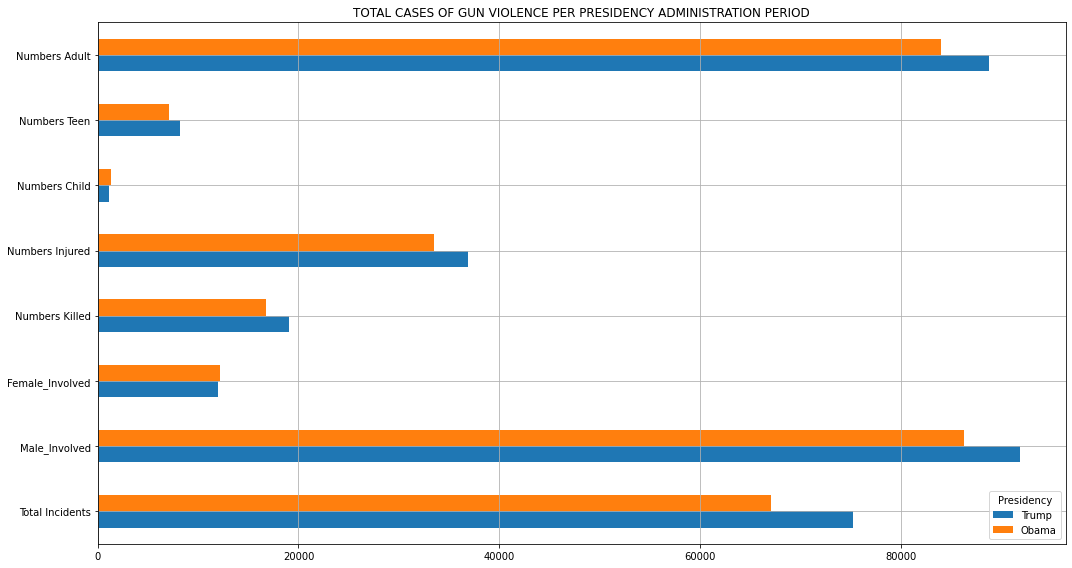

In [138]:
# Graph Gun Violence
pres_summary_df.T.plot.barh(legend=True, figsize=(15,8), rot =0)
    
plt.subplots_adjust(bottom= 0.2, top = 0.98)


plt.title(f"TOTAL CASES OF GUN VIOLENCE PER PRESIDENCY ADMINISTRATION PERIOD")
plt.tight_layout()
plt.grid(True)
plt.show()


In [139]:
#graph

# ObamaTrump = pres_summary_df.plot(kind="bar", figsize=(10,5))
# multi_plot.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=4)

# # Plot x and y labels and title
# plt.title('Obama vs Trump Incidents/Involvements (15 Months)')
# plt.xlabel('Presidency')
# plt.ylabel('Numbers')

# plt.show()
# plt.tight_layout()

In [140]:
# Summary by months for each precidency - for graphs

fil_Crime= re_Crime.loc[(re_Crime["Presidency"] == 'Trump')]

Total_Incident = fil_Crime.groupby("Year Month").count()['Incident']
killed = fil_Crime.groupby(["Year Month"]).sum()["Number Killed"]
injured = fil_Crime.groupby(["Year Month"]).sum()["Number Injured"]
male = fil_Crime.groupby(["Year Month"]).sum()["Male"]
female = fil_Crime.groupby(["Year Month"]).sum()["Female"]
child = fil_Crime.groupby(["Year Month"]).sum()["Child 0-11"]
teen = fil_Crime.groupby(["Year Month"]).sum()["Teen 12-17"]
adult = fil_Crime.groupby(["Year Month"]).sum()["Adult 18+"]


trump_months = pd.DataFrame({
                             
                             "Total Incidents":Total_Incident,
                              "Male":male,
                              "Female":female,
                              "Killed":killed,
                              "Injured":injured,
                              "Child":child,
                              "Teen":teen,
                              "Adult":adult
                             })
trump_months.head()

,Total Incidents,Male,Female,Killed,Injured,Child,Teen,Adult
Year Month,,,,,,,,
2017-01,5258,6800.0,849.0,1356.0,2604.0,67.0,594.0,6506.0
2017-02,4585,5605.0,742.0,1141.0,2197.0,63.0,511.0,5513.0
2017-03,4994,5941.0,825.0,1220.0,2233.0,68.0,513.0,5835.0
2017-04,5577,6366.0,793.0,1231.0,2648.0,71.0,534.0,6053.0
2017-05,5666,6749.0,825.0,1389.0,2732.0,92.0,589.0,6455.0


In [141]:
fil_Crime= re_Crime.loc[(re_Crime["Presidency"] == 'Obama')]

Total_Incident = fil_Crime.groupby("Year Month").count()['Incident']
killed = fil_Crime.groupby(["Year Month"]).sum()["Number Killed"]
injured = fil_Crime.groupby(["Year Month"]).sum()["Number Injured"]
male = fil_Crime.groupby(["Year Month"]).sum()["Male"]
female = fil_Crime.groupby(["Year Month"]).sum()["Female"]
child = fil_Crime.groupby(["Year Month"]).sum()["Child 0-11"]
teen = fil_Crime.groupby(["Year Month"]).sum()["Teen 12-17"]
adult = fil_Crime.groupby(["Year Month"]).sum()["Adult 18+"]


Obama_months = pd.DataFrame({
                             
                             "Total Incidents":Total_Incident,
                              "Male":male,
                              "Female":female,
                              "Killed":killed,
                              "Injured":injured,
                              "Child":child,
                              "Teen":teen,
                              "Adult":adult
                             })
Obama_months.head()

,Total Incidents,Male,Female,Killed,Injured,Child,Teen,Adult
Year Month,,,,,,,,
2015-01,3907,5105.0,670.0,1123.0,1808.0,71.0,397.0,5129.0
2015-02,3108,3803.0,620.0,870.0,1378.0,64.0,299.0,3895.0
2015-03,4314,5527.0,842.0,1090.0,2093.0,110.0,483.0,5550.0
2015-04,4471,5524.0,814.0,995.0,2149.0,87.0,414.0,5650.0
2015-05,5015,6453.0,873.0,1164.0,2677.0,127.0,508.0,6450.0


### Obama and Trump Mean, Median, Variance, Standard Deviation and Standard Error

In [142]:
# Trump/Obama Analysis Killed - monthly

killed_Mean = round(trump_months.mean()['Killed'])
killed_Median = trump_months.median()['Killed']
killed_Var = round(trump_months.var()['Killed'])
killed_sds = round(trump_months.std()['Killed'])
killed_sems = round(trump_months.sem()['Killed'])

summary_Trump_killed = pd.DataFrame({'Presidency admin' : ['Trump'], "killed Mean":killed_Mean,
                              "killed Median":killed_Median,
                              "killed Variance":killed_Var,
                              "killed Std. Dev":killed_sds,
                              "killed Std. Err":killed_sems })
summary_Trump_killed



,Presidency admin,killed Mean,killed Median,killed Variance,killed Std. Dev,killed Std. Err
0,Trump,1270,1304.0,9659,98,25


In [143]:
# Trump/Obama Analysis Killed - monthly

killed_Mean = round(Obama_months.mean()['Killed'])
killed_Median = Obama_months.median()['Killed']
killed_Var = round(Obama_months.var()['Killed'])
killed_sds = round(Obama_months.std()['Killed'])
killed_sems = round(Obama_months.sem()['Killed'])

summary_Obama_killed = pd.DataFrame({'Presidency admin' : ['Obama'], "killed Mean":killed_Mean,
                              "killed Median":killed_Median,
                              "killed Variance":killed_Var,
                              "killed Std. Dev":killed_sds,
                              "killed Std. Err":killed_sems })
summary_Obama_killed



,Presidency admin,killed Mean,killed Median,killed Variance,killed Std. Dev,killed Std. Err
0,Obama,1119,1133.0,11566,108,28


## Obama vs Trump by State

In [144]:
Total_killed = re_Crime.groupby("State").sum()['Number Killed']
Total_killed.sort_values(ascending =False).head(9)

State
California        3215.0
Texas             2925.0
Florida           2242.0
Illinois          1991.0
Ohio              1505.0
Georgia           1497.0
Pennsylvania      1410.0
Missouri          1332.0
North Carolina    1292.0
Name: Number Killed, dtype: float64

In [145]:
killed_Crime = re_Crime.loc[(re_Crime["Presidency"] == 'Obama')]

Total_killed = killed_Crime.groupby("State").sum()['Number Killed']

obama = Total_killed.sort_values(ascending =False).head(11)

obama


State
California        1488.0
Texas             1446.0
Florida           1025.0
Illinois           867.0
Georgia            711.0
Ohio               666.0
Pennsylvania       639.0
North Carolina     628.0
Louisiana          596.0
Missouri           595.0
New York           548.0
Name: Number Killed, dtype: float64

In [146]:
killed_Crime= re_Crime.loc[(re_Crime["Presidency"] == 'Trump')]

Total_killed = killed_Crime.groupby("State").sum()['Number Killed']

trump = Total_killed.sort_values(ascending =False).head(11)

trump

State
California        1727.0
Texas             1479.0
Florida           1217.0
Illinois          1124.0
Ohio               839.0
Georgia            786.0
Pennsylvania       771.0
Missouri           737.0
Alabama            679.0
Louisiana          678.0
North Carolina     664.0
Name: Number Killed, dtype: float64

In [147]:
killed_state_merge = pd.merge(obama, trump, on ='State',how = 'inner')
killed_state_merge =killed_state_merge.rename(columns= {"No. of Killed People_x":"Killed_Obama",
                                                  "No. of Killed People_y":"Killed_Trump"})
killed_state_merge

,Number Killed_x,Number Killed_y
State,,
California,1488.0,1727.0
Texas,1446.0,1479.0
Florida,1025.0,1217.0
Illinois,867.0,1124.0
Georgia,711.0,786.0
Ohio,666.0,839.0
Pennsylvania,639.0,771.0
North Carolina,628.0,664.0
Louisiana,596.0,678.0


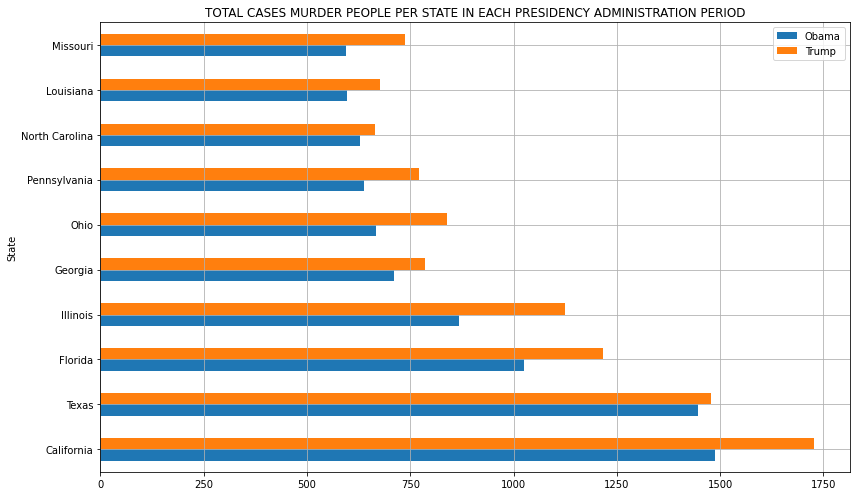

In [150]:
#Graph of top ten states of gun Violation Incident counts:

killed_state_merge.plot.barh(legend=True, figsize=(12,7), rot =0) 
plt.subplots_adjust(bottom= 0.2, top = 0.98)
# rename legend
L=plt.legend()
L.get_texts()[0].set_text('Obama')
L.get_texts()[1].set_text('Trump')
plt.title(f"TOTAL CASES MURDER PEOPLE PER STATE IN EACH PRESIDENCY ADMINISTRATION PERIOD")
plt.tight_layout()
plt.grid(True)
plt.show()

In [111]:
# Trump/Obama Analysis Killed - monthly

killed_Mean = round(trump_months.mean()['Killed'])
killed_Median = trump_months.median()['Killed']
killed_Var = round(trump_months.var()['Killed'])
killed_sds = round(trump_months.std()['Killed'])
killed_sems = round(trump_months.sem()['Killed'])

summary_Trump_killed = pd.DataFrame({'Presidency admin' : ['Trump'], "killed Mean":killed_Mean,
                              "killed Median":killed_Median,
                              "killed Variance":killed_Var,
                              "killed Std. Dev":killed_sds,
                              "killed Std. Err":killed_sems })




In [112]:
# Obama Analysis Killed - monthly
killed_Mean = round(Obama_months.mean()['Killed'])
killed_Median = Obama_months.median()['Killed']
killed_Var = round(Obama_months.var()['Killed'])
killed_sds = round(Obama_months.std()['Killed'])
killed_sems = round(Obama_months.sem()['Killed'])

summary_Obama_killed = pd.DataFrame({'Presidency admin' : ['Obama'], "killed Mean":killed_Mean,
                              "killed Median":killed_Median,
                              "killed Variance":killed_Var,
                              "killed Std. Dev":killed_sds,
                              "killed Std. Err":killed_sems })

In [113]:
# Demographic Statistic by Presidency
combine_df = [summary_Trump_killed, summary_Obama_killed]
pres_summary_killed= pd.concat(combine_df)
pres_summary_killed

,Presidency admin,killed Mean,killed Median,killed Variance,killed Std. Dev,killed Std. Err
0,Trump,1270,1304.0,9659,98,25
0,Obama,1119,1133.0,11566,108,28


### HEATMAP: Killed counts by state - TRUMP

In [54]:
# TOP 5 STATES
# Store 'Latitude' and 'Longitude' into  locations
state_list = ['California','Texas','Florida','Illinois','Ohio']
#state_list = ['California','Texas','Florida','Illinois','Ohio','Georgia','Pennsylvania','Missouri','North Carolina','Louisiana']
trump_killed = re_Crime.loc[(re_Crime["Presidency"] == 'Trump')].dropna()
trump_killed["TopTen States"] = trump_killed["State"].isin(state_list)
trump_killed_topstate = trump_killed.loc[(trump_killed["TopTen States"] == True)]
trump_killed_cleaned = trump_killed_topstate.loc[(trump_killed_topstate["Number Killed"] > 0)]
locations = trump_killed_cleaned[["Latitude", "Longitude"]].astype(float)
# Convert Killed counts to float and store
gun_killed = trump_killed_cleaned["Number Killed"].tolist()
fig = gmaps.figure()
# Create a Marker layer
guncrime_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"crime: {crime}" for crime in gun_killed]
)
fig = gmaps.figure()
fig.add_layer(guncrime_layer)
fig


Figure(layout=FigureLayout(height='420px'))

t-Test to statistically significant as P < 0.05 and statistically highly significant as P < 0.001 (less than one in a thousand chance of being wrong) Prove our Hypothesis/Null Hypothesis

In [114]:
# T Testing for Killed Counts per month

population1 = Obama_months["Killed"]
population2 = trump_months["Killed"]

stats.ttest_ind(population1, population2, equal_var=False)



Ttest_indResult(statistic=-3.998166236234966, pvalue=0.0004271047689859947)

In [115]:
print(f"HIGHLY statistical confirmation that Killed Counts per month in two presidency administrations are different")


HIGHLY statistical confirmation that Killed Counts per month in two presidency administrations are different
